In [1]:
import sys
import matplotlib
%matplotlib inline
import argparse
from nbfinder import NotebookFinder
sys.meta_path.append(NotebookFinder())
from notebooks.data_loader import load_data
from notebooks.train_val import train
from notebooks.helper_fxns import create_run_dir, dump_hyperparams, get_input_dims
from notebooks.build_network import build_network

importing Jupyter notebook from notebooks/data_loader.ipynb
importing Jupyter notebook from notebooks/train_val.ipynb
importing Jupyter notebook from notebooks/helper_fxns.ipynb
importing Jupyter notebook from notebooks/print_n_plot.ipynb
importing Jupyter notebook from notebooks/build_network.ipynb


Opening /global/project/projectdirs/das/wbhimji/RPVSusyJetLearn/jj_DAOD_EXOT3.h5 in read-only mode
Opening /global/project/projectdirs/das/wbhimji/RPVSusyJetLearn/DAOD_EXOT3.08548071._000001.pool.root.1.h5 in read-only mode
Starting training...
Epoch 1 of 11 took 3.410s
	training los:		0.6935
	training acc:		50.0000 %
  validation loss:		0.711267
  validation accuracy:		40.00 %
Epoch 2 of 11 took 3.291s
	training los:		0.6933
	training acc:		50.0000 %
  validation loss:		0.711242
  validation accuracy:		50.00 %
Epoch 3 of 11 took 2.482s
	training los:		0.6931
	training acc:		50.0000 %
  validation loss:		0.711204
  validation accuracy:		50.00 %
Epoch 4 of 11 took 2.877s
	training los:		0.6927
	training acc:		50.0000 %
  validation loss:		0.711178
  validation accuracy:		50.00 %
Epoch 5 of 11 took 3.205s
	training los:		0.6923
	training acc:		53.3333 %
  validation loss:		0.711142
  validation accuracy:		50.00 %
Epoch 6 of 11 took 2.994s
	training los:		0.6918
	training acc:		53.3333 %


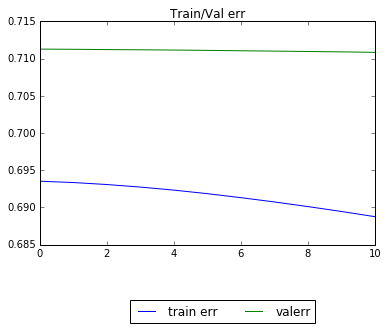

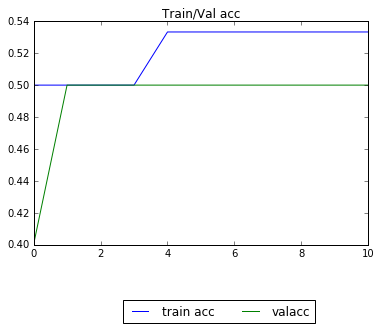

In [2]:
num_epochs = 11
learning_rate = 0.0001
num_events = 40
weight_decay = 0
num_filters = 128
num_fc_units = 100
dropout_p = 0
# parser = argparse.ArgumentParser()
# parser.add_argument('-e', '--epochs', type=int, default=10,
#     help='number of epochs for training')

# parser.add_argument('-l', '--learn_rate', default=0.0001, type=float,
#     help='the learning rate for the network')

# parser.add_argument('-n', '--num_events', default=40, type=int,
#     help='number of total images')

# args = parser.parse_args()
# num_epochs = args.epochs
# learning_rate = args.learn_rate
# num_events = args.num_events


run_dir = create_run_dir()

dataset = load_data(num_events=50)


'''set params'''
network_kwargs = {'input_shape':(None,1,100,100), 'learning_rate': learning_rate, 'dropout_p': dropout_p, 
                  'weight_decay': weight_decay, 'num_filters': num_filters, 'num_fc_units': num_fc_units}

'''get network and train_fns'''
train_fn, val_fn, network, hyperparams = build_network(**network_kwargs)

'''save hyperparams'''
dump_hyperparams(hyperparams, path=run_dir)

'''train'''
train(dataset, network=network,train_fn=train_fn, val_fn=val_fn, num_epochs=num_epochs, save_path=run_dir)